# Question 4 - Visualisations simples #

In [432]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
sys.path.append(os.path.abspath("../"))
from features.Pbp_DataFrame import Pbp_to_DataFrame

In [433]:
# Dataframe avec tous les jeux d'une saison
def get_season_df(season):
    data_path = '../../games_data'
    season_folder = os.path.join(data_path, season)
    
    games_dfs = []
    
    for game in os.listdir(season_folder):
        game_id = os.path.splitext(game)[0]
        game_df = Pbp_to_DataFrame().build_game_DataFrame(game_id)
        if game_df.empty:
            print(f"Empty DataFrame for game {game_id}")
        else:
            games_dfs.append(game_df)
        
    season_df = pd.concat(games_dfs, ignore_index=True)
    
    return season_df
    

## 1. Graphique comparant les types de tirs de toutes les équipes dans la saison 2023-2024 ##

In [434]:
def get_shots_frequency_by_type(df):

    # Count number of shots and goals (columns) for each type (rows)
    count_df = pd.crosstab(df['Type of Shot'], df['Event Type'])

    # Supprimer la ligne "Unknown"
    count_df = count_df.drop(index="Unknown", errors="ignore")

    return count_df
    

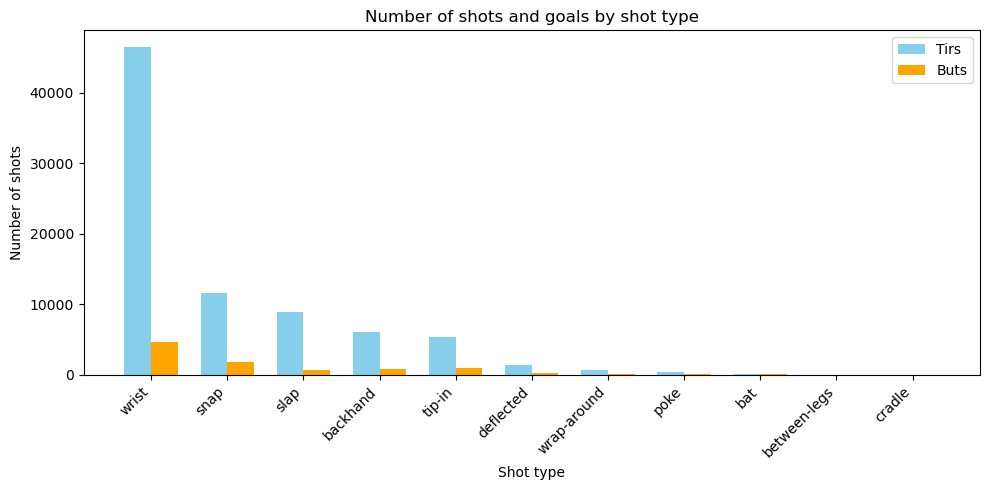

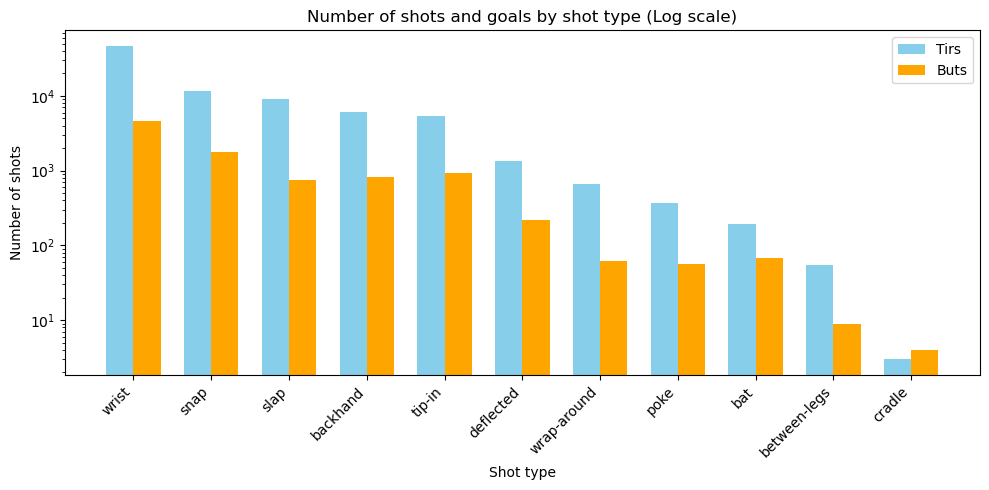

In [435]:
# Graphique
df = get_season_df('2023-2024')
count_df = get_shots_frequency_by_type(df)

# Trier
count_df = count_df.sort_values(by='Shot', ascending=False)

# Extraire données triées
shot_types = count_df.index.tolist()
shots_count = count_df['Shot'].tolist()
goals_count = count_df['Goal'].tolist()

# Positions
x = np.arange(len(shot_types))
width = 0.35

plt.figure(figsize=(10,5))

# Plot bars
plt.bar(x - width/2, shots_count, width, label='Tirs', color='skyblue')
plt.bar(x + width/2, goals_count, width, label='Buts', color='orange')
# plt.yscale('log')

# Labels and title
plt.ylabel('Number of shots')
plt.xlabel('Shot type')
plt.title('Number of shots and goals by shot type')
plt.xticks(x, shot_types, rotation=45, ha='right')
plt.legend()

plt.tight_layout()
plt.show()


# LOG scale 
plt.figure(figsize=(10,5))

# Plot bars
plt.bar(x - width/2, shots_count, width, label='Tirs', color='skyblue')
plt.bar(x + width/2, goals_count, width, label='Buts', color='orange')
plt.yscale('log')

# Labels and title
plt.ylabel('Number of shots')
plt.xlabel('Shot type')
plt.title('Number of shots and goals by shot type (Log scale)')
plt.xticks(x, shot_types, rotation=45, ha='right')
plt.legend()

plt.tight_layout()
plt.show()


### (b) Trouver la distance des tirs ###

In [436]:
def get_shot_distance(event):

    # Goal coordinates 
    left_goal = (-89, 0)
    right_goal = (89, 0)
    
    # Event coordinates
    x_coord = event['X']
    y_coord = event['Y']
    
    if pd.isna(x_coord) or pd.isna(y_coord):    # Handle missing coordinates
        return None
    
    # Calculate distances to both goals
    dist_left = np.sqrt((x_coord - left_goal[0])**2 + (y_coord - left_goal[1])**2)
    dist_right = np.sqrt((x_coord - right_goal[0])**2 + (y_coord - right_goal[1])**2)

    # Choose the shorter distance
    shot_distance = min(dist_left, dist_right)
    
    return shot_distance.round(1)

### (a) Relation entre la distance à laquelle un tir a été effectué et la chance qu'il s'agisse d'un but ###

In [437]:
def get_shots_distances(season):
    df = get_season_df(season)

    df['Distance'] = df.apply(get_shot_distance, axis=1)     # Compute distance for all events
    df = df[['Event Type', 'Type of Shot', 'Distance']]     # Kepp only useful information
    df = df[df['Type of Shot'] != "Unknown"]
    df = df.dropna(subset=['Distance'])     # Delete events with no distance computed (due to missing data)
    
    rounded_df = df.copy()
    rounded_df['Distance'] = rounded_df['Distance'].round()
    
    return df, rounded_df

#### Saison 2018-2019 ####

In [438]:
df, rounded_df = get_shots_distances('2018-2019')

Empty DataFrame for game 2018010110
Empty DataFrame for game 2018010109


/var/folders/ht/5dt3l6tj3l77w68350y2_c080000gn/T/ipykernel_8626/2056005950.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  season_df = pd.concat(games_dfs, ignore_index=True)


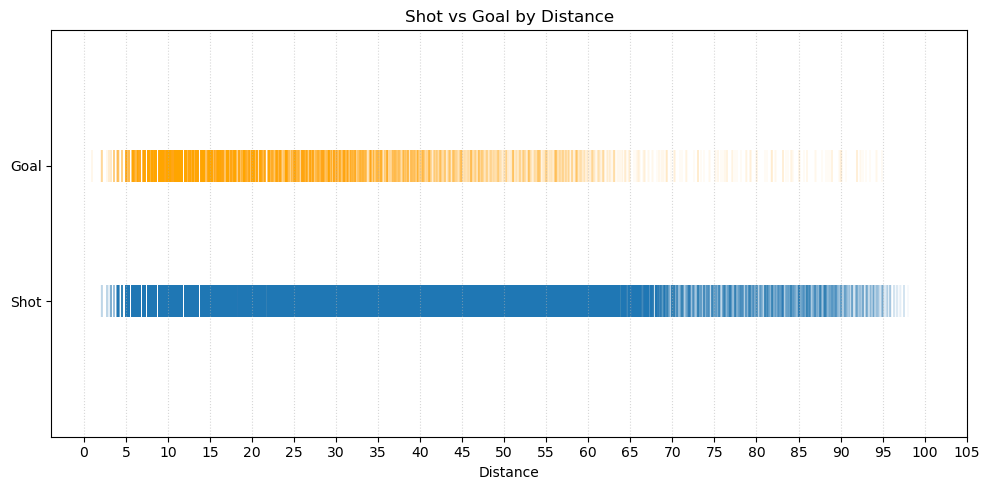

In [439]:
def plot1D(df):
    shots_distance = df[df['Event Type'] == 'Shot']['Distance'].tolist()
    goals_distance = df[df['Event Type'] == 'Goal']['Distance'].tolist()

    plt.figure(figsize=(10,5))

    # Plot shots at y=0.1
    plt.scatter(shots_distance, [0.1] * len(shots_distance),
                alpha=0.04, label="Shot", s=500, marker="|")

    # Plot goals at y=0.2
    plt.scatter(goals_distance, [0.2] * len(goals_distance),
                alpha=0.04, label="Goal", s=500, color="orange", marker="|")

    # Customize y-axis
    plt.ylim(0, 0.3)
    plt.yticks([0.1, 0.2], ["Shot", "Goal"])
    plt.xlabel("Distance")
    plt.title("Shot vs Goal by Distance")
    plt.grid(axis="x", linestyle=":", alpha=0.5)
    max_distance = max(max(shots_distance), max(goals_distance))
    plt.xticks(np.arange(0, max_distance + 10, 5))
    
    plt.tight_layout()
    plt.show()
    
plot1D(df)

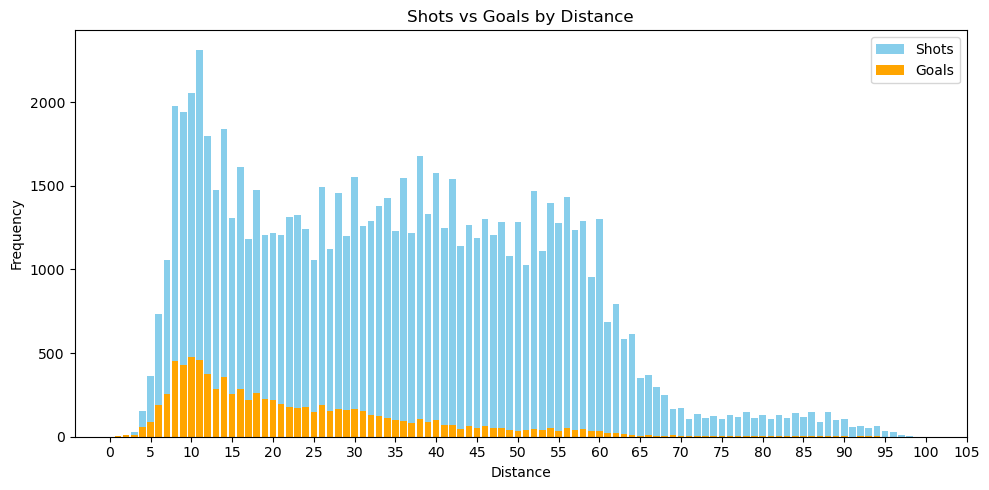

In [440]:
def barsPlot(df):
    # Count frequency of each distance
    shots_distance_frequency = df[df['Event Type'] == 'Shot']['Distance'].value_counts().sort_index()
    goals_distance_frequency = df[df['Event Type'] == 'Goal']['Distance'].value_counts().sort_index()
    # Extract unique distances and their frequencies
    shots_x = np.array(shots_distance_frequency.index)
    shots_y = np.array(shots_distance_frequency.values)

    goals_x = np.array(goals_distance_frequency.index)
    goals_y = np.array(goals_distance_frequency.values)

    plt.figure(figsize=(10, 5))

    # Plot shots
    plt.bar(shots_x, shots_y, color="skyblue", label="Shots")

    # Plot goals (overlay, different color)
    plt.bar(goals_x, goals_y, color="orange", label="Goals")

    # Labels & legend
    plt.xticks(np.arange(0, max(max(shots_x), max(goals_x)) + 10, 5))
    plt.xlabel("Distance")
    plt.ylabel("Frequency")
    plt.title("Shots vs Goals by Distance")
    plt.legend()
    plt.tight_layout()
    # plt.show()
    
    
barsPlot(rounded_df)

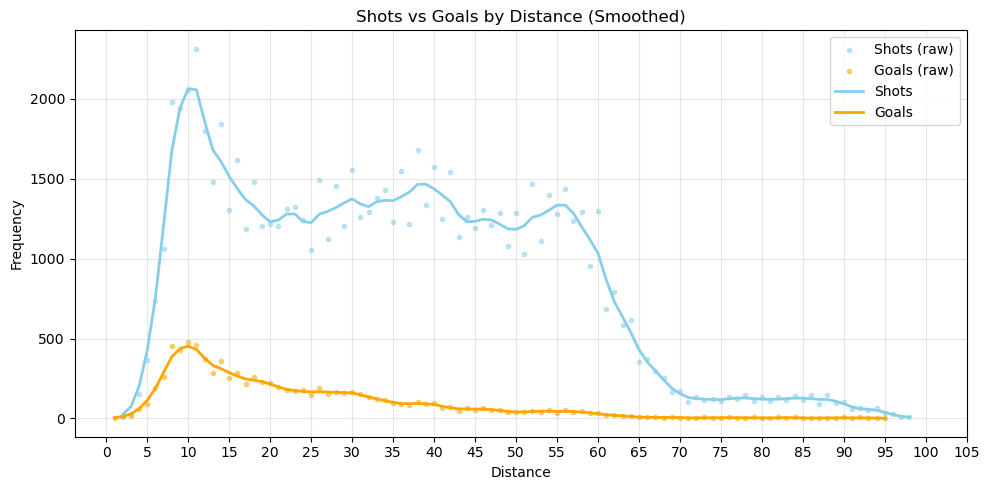

In [441]:
from scipy.ndimage import gaussian_filter1d

def smoothCurvePlot(df):

    # Count frequency of each distance
    shots_distance_frequency = df[df['Event Type'] == 'Shot']['Distance'].value_counts().sort_index()
    goals_distance_frequency = df[df['Event Type'] == 'Goal']['Distance'].value_counts().sort_index()

    # Extract unique distances and their frequencies
    shots_x = np.array(shots_distance_frequency.index)
    shots_y = np.array(shots_distance_frequency.values)

    goals_x = np.array(goals_distance_frequency.index)
    goals_y = np.array(goals_distance_frequency.values)

    plt.figure(figsize=(10, 5))

    # Smooth values
    shots_y_smooth = gaussian_filter1d(shots_y, sigma=1)
    goals_y_smooth = gaussian_filter1d(goals_y, sigma=1)
    
    # Plot raw data as points
    plt.scatter(shots_x, shots_y, color="skyblue", alpha=0.5, marker=".", label="Shots (raw)")
    plt.scatter(goals_x, goals_y, color="orange", alpha=0.5, marker=".", label="Goals (raw)")

    # Plot smooth curves
    plt.plot(shots_x, shots_y_smooth, color="skyblue", label="Shots", linewidth=2)
    plt.plot(goals_x, goals_y_smooth, color="orange", label="Goals", linewidth=2)

    # Labels & legend
    plt.xticks(np.arange(0, max(max(shots_x), max(goals_x)) + 10, 5))
    plt.xlabel("Distance")
    plt.ylabel("Frequency")
    plt.title("Shots vs Goals by Distance (Smoothed)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    
smoothCurvePlot(rounded_df)


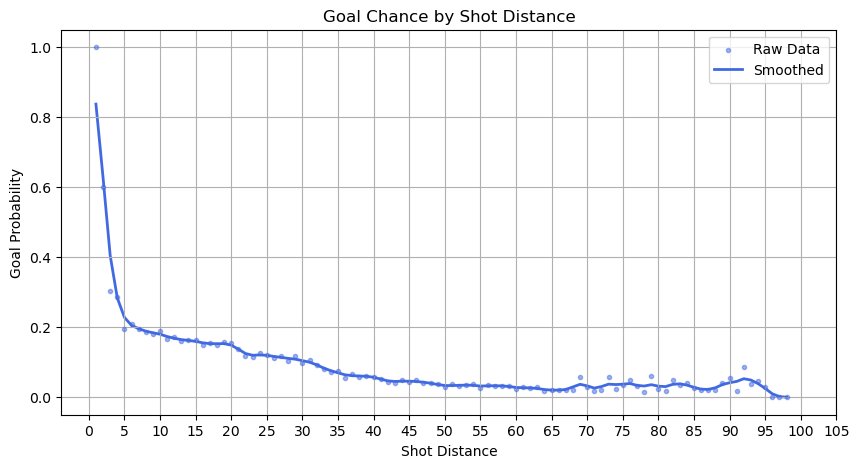

In [442]:
def goalChancePlot(df):
    
    shots_distance_frequency = df[df['Event Type'] == 'Shot']['Distance'].value_counts().sort_index()
    goals_distance_frequency = df[df['Event Type'] == 'Goal']['Distance'].value_counts().sort_index()

    total_shots_distance_frequency = shots_distance_frequency.add(goals_distance_frequency, fill_value=0)

    # TODO
    goal_chance_by_distance = goals_distance_frequency.divide(total_shots_distance_frequency, fill_value=0)
    # goal_chance_by_distance = goals_distance_frequency.divide(df.shape[0], fill_value=0)

    chance_smooth = gaussian_filter1d(goal_chance_by_distance.values, sigma=1)

    plt.figure(figsize=(10, 5))

    # Raw data as points
    plt.scatter(
        goal_chance_by_distance.index, 
        goal_chance_by_distance.values, 
        color='royalblue', 
        label='Raw Data', 
        zorder=2,
        marker=".",
        alpha=0.5
    )

    # Smoothed line
    plt.plot(
        goal_chance_by_distance.index, 
        chance_smooth, 
        color='royalblue', 
        label='Smoothed', 
        linewidth=2, 
        zorder=1,
        alpha=1
    )

    plt.xticks(np.arange(0, max(goal_chance_by_distance.index) + 10, 5))
    plt.title('Goal Chance by Shot Distance')
    plt.xlabel('Shot Distance')
    plt.ylabel('Goal Probability')
    plt.grid(True)
    plt.legend()
    plt.show()


goalChancePlot(rounded_df)

#### Saison 2019-2020 ####

Empty DataFrame for game 2019010106
Empty DataFrame for game 2019010107


/var/folders/ht/5dt3l6tj3l77w68350y2_c080000gn/T/ipykernel_8626/2056005950.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  season_df = pd.concat(games_dfs, ignore_index=True)


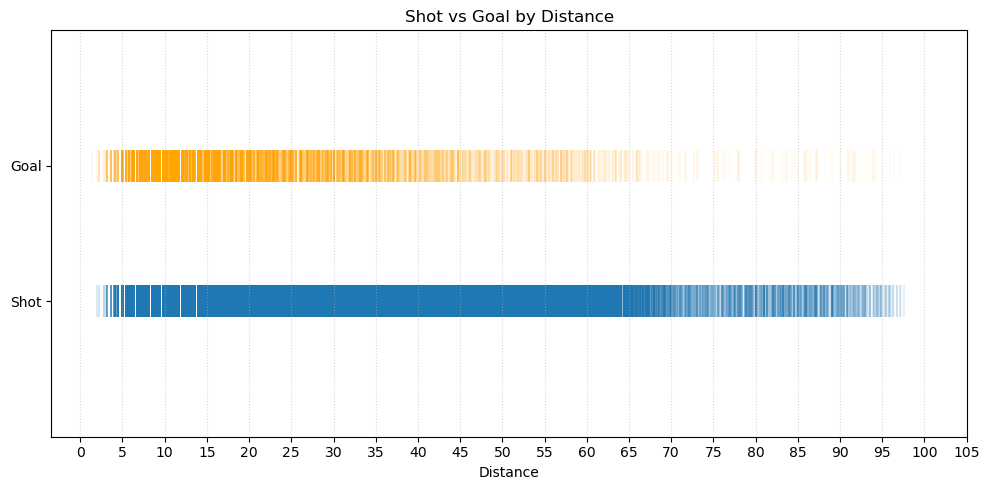

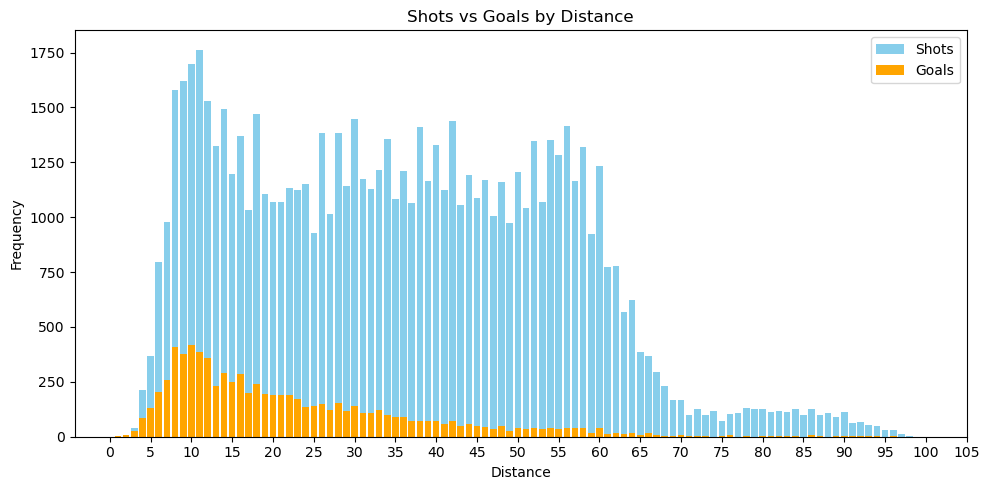

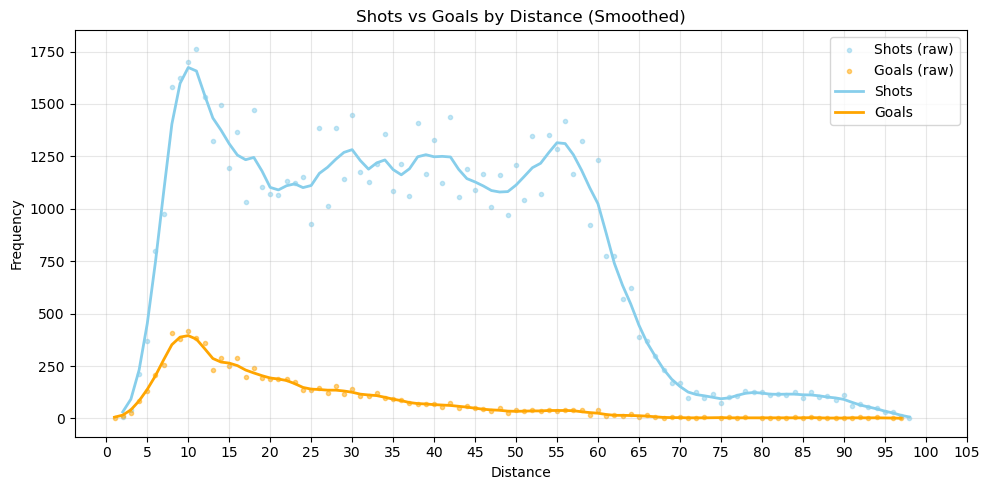

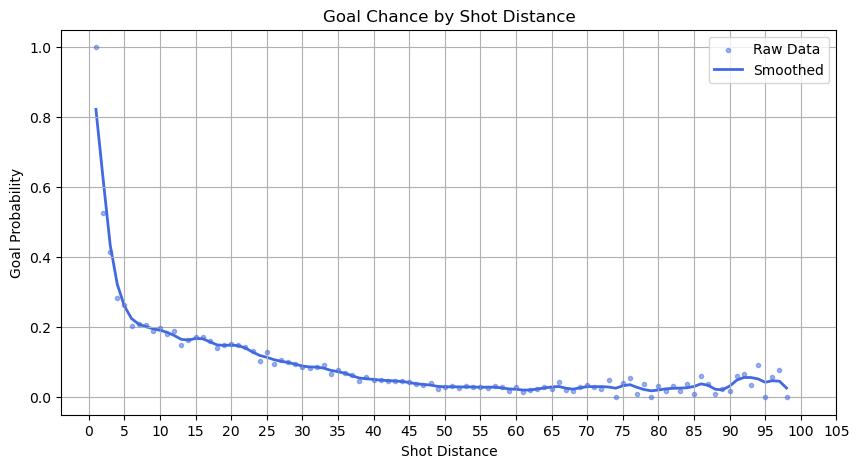

In [443]:
df, rounded_df = get_shots_distances('2019-2020')

plot1D(df)
barsPlot(rounded_df)
smoothCurvePlot(rounded_df)
goalChancePlot(rounded_df)

#### Saison 2020-2021 ####

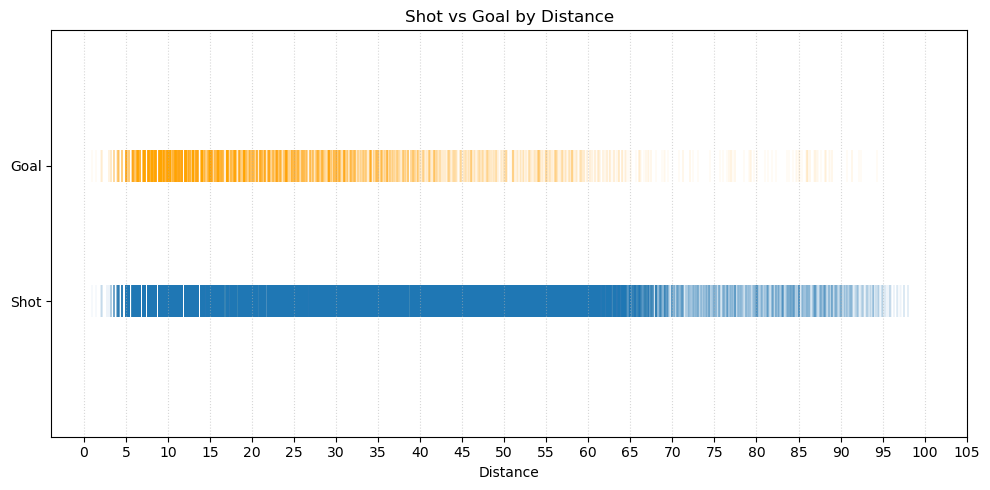

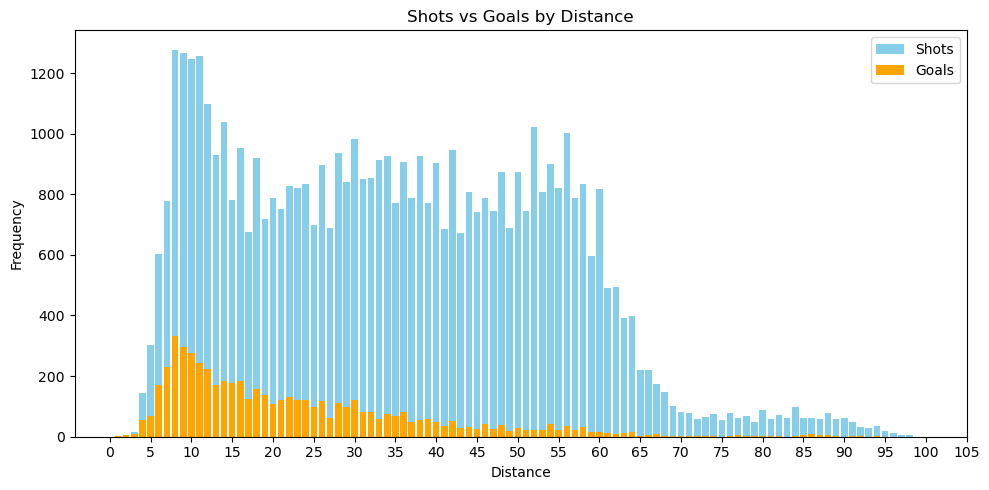

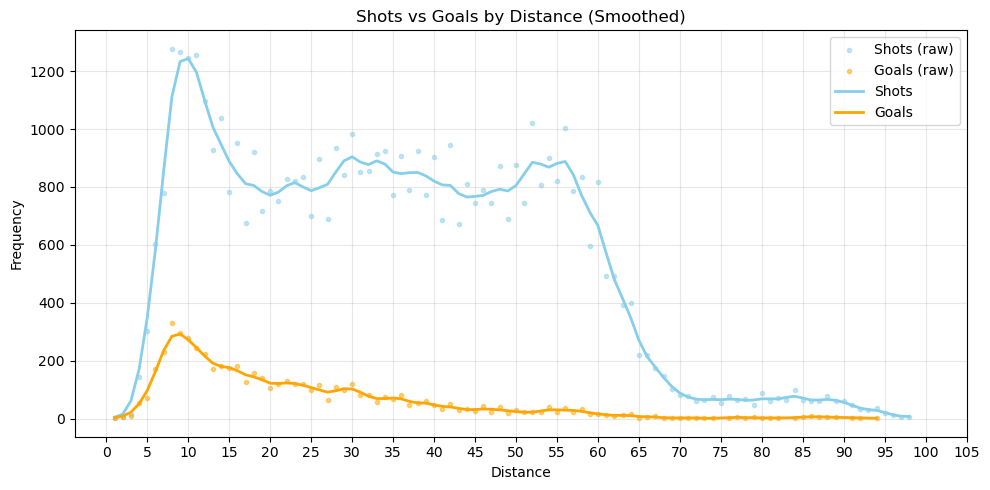

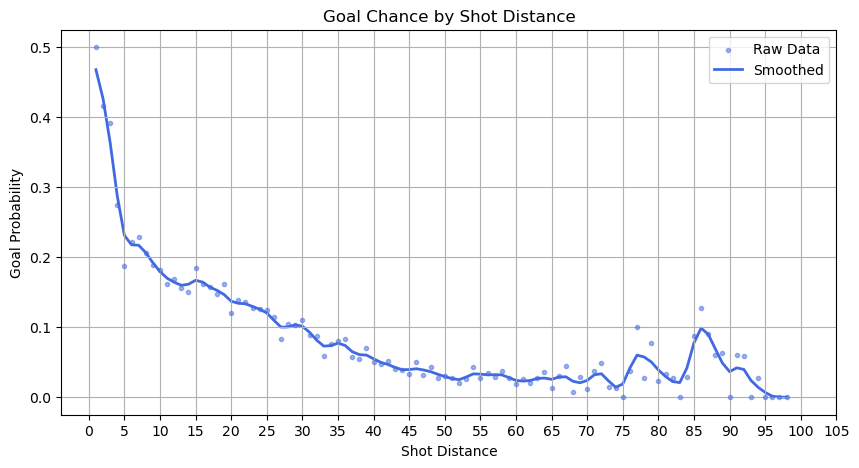

In [444]:
df, rounded_df = get_shots_distances('2020-2021')

plot1D(df)
barsPlot(rounded_df)
smoothCurvePlot(rounded_df)
goalChancePlot(rounded_df)

## 2. Pourcentage de buts en fonction de la distance et du type de tir pour la saison 2023-2024 ##

In [445]:
distances_df, rounded_distances_df = get_shots_distances('2023-2024')
# count_df = get_shots_frequency_by_type(distances_df)
# count_df['Total'] = count_df['Goal'] + count_df['Shot']

shots_distance = rounded_distances_df[rounded_distances_df['Event Type']=='Shot']
grouped_shots_data = shots_distance.groupby(['Type of Shot', 'Distance'])
shots_distance_frequency_by_type = grouped_shots_data.size().unstack(fill_value=0)

goals_distance = rounded_distances_df[rounded_distances_df['Event Type']=='Goal']
grouped_goals_data = goals_distance.groupby(['Type of Shot', 'Distance'])
goals_distance_frequency_by_type = grouped_goals_data.size().unstack(fill_value=0)

total_shots_distance_frequency_by_type = shots_distance_frequency_by_type.add(goals_distance_frequency_by_type, fill_value=0)

# print(rounded_distances_df[rounded_distances_df['Distance']==1].shape[0])
# print(total_shots_distance_frequency_by_type[1].sum())

# TODO
# goal_percentage_by_distance_and_type = goals_distance_frequency_by_type.divide(rounded_df.shape[0], fill_value=0)
goal_percentage_by_distance_and_type = goals_distance_frequency_by_type.divide(total_shots_distance_frequency_by_type, fill_value=0)
goal_percentage_by_distance_and_type = goal_percentage_by_distance_and_type.fillna(0)

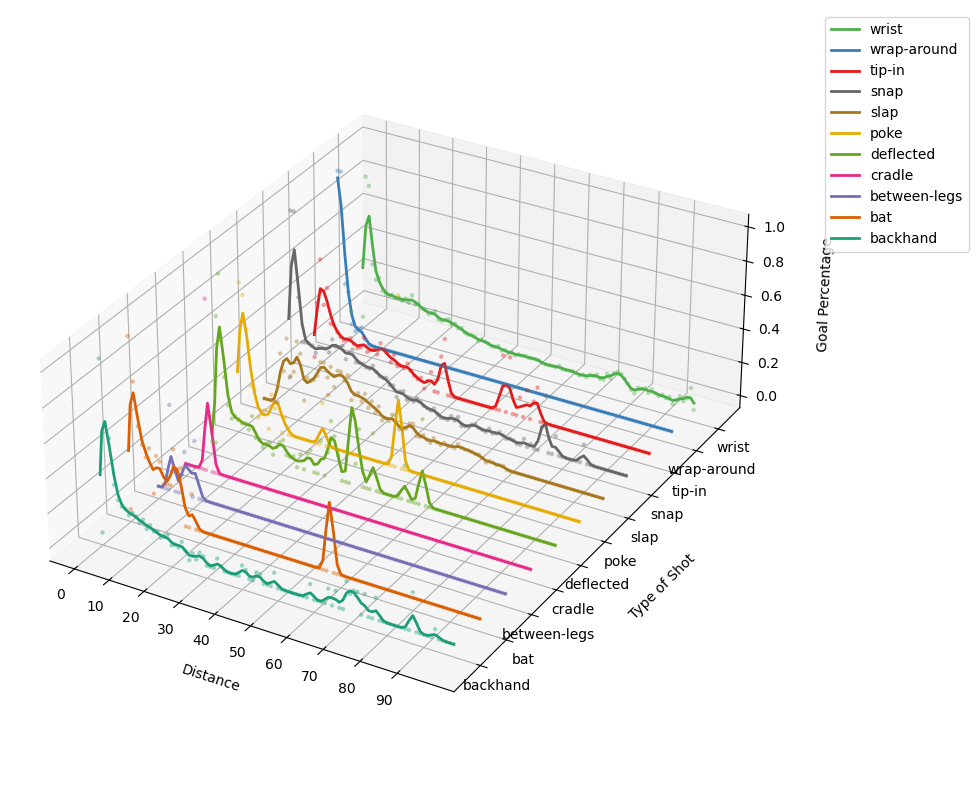

In [446]:
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')

# Sort distances 
distances = goal_percentage_by_distance_and_type.columns.astype(float).sort_values()
shot_types = goal_percentage_by_distance_and_type.index.tolist()

# Colors
dark2_colors = plt.colormaps['Dark2'].colors
set1_colors = plt.colormaps['Set1'].colors
colors = list(dark2_colors) + list(set1_colors[:3])

# Increase spacing between shot types
y_spacing = 50

for i, shot_type in reversed(list(enumerate(shot_types))):
    values = goal_percentage_by_distance_and_type.loc[shot_type, distances].values
    
    # Smoothed curve
    smooth_values = gaussian_filter1d(values, sigma=1)
    y = np.full_like(distances, i * y_spacing)
    
    # Raw data points (lighter)
    ax.scatter(distances, y, values, color=colors[i], alpha=0.3, s=20, marker=".")
    
    # Smoothed curve
    ax.plot(distances, y, smooth_values, color=colors[i], linewidth=2, label=shot_type)

# Axis labels with more padding
ax.set_xlabel('Distance', labelpad=10)
ax.set_ylabel('Type of Shot', labelpad=20)
ax.set_zlabel('Goal Percentage', labelpad=15)

# Place shot type labels with spacing
yticks = [i * y_spacing for i in range(len(shot_types))]
ax.set_yticks(yticks)
ax.set_yticklabels(shot_types)

# Force limits so spacing is respected
ax.set_ylim(min(yticks) - y_spacing, max(yticks) + y_spacing)

# legend outside
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Make Y axis stretched (no cube aspect ratio)
ax.set_box_aspect([6, 8, 3])  

# Set distance ticks every 10
ax.set_xticks(np.arange(int(distances.min()), int(distances.max())+1, 10))

plt.show()

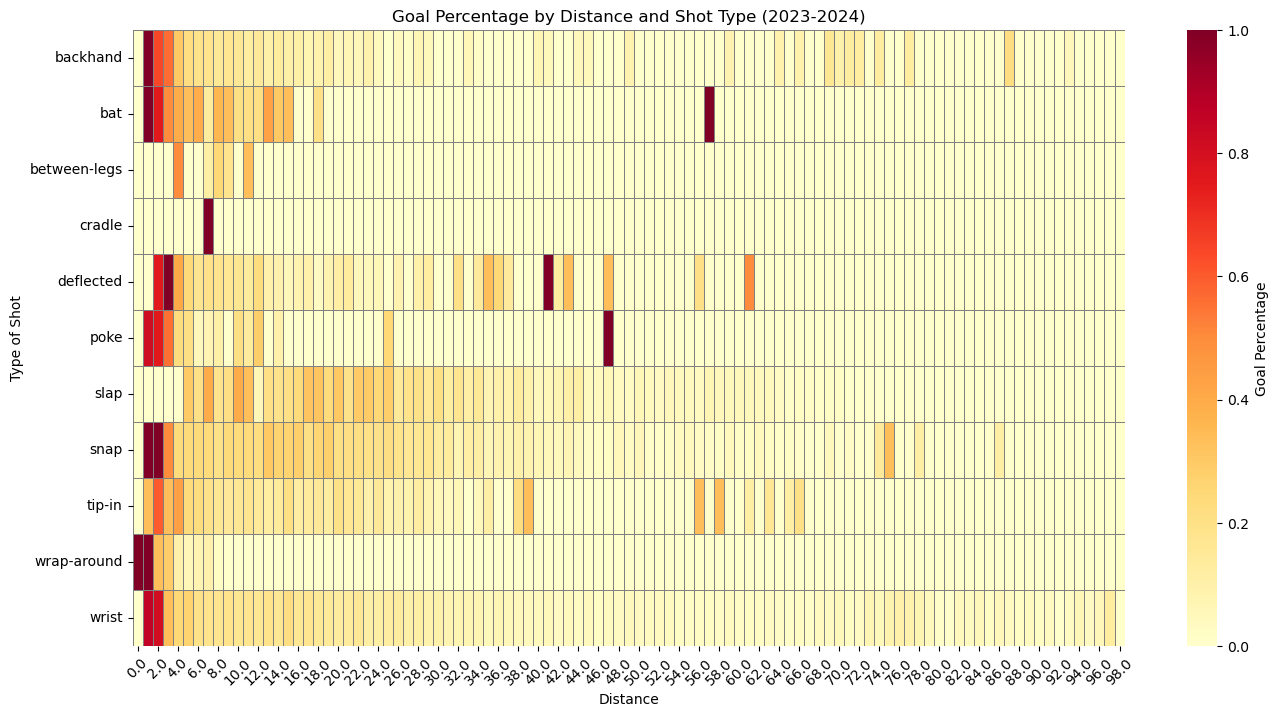

In [447]:
plt.figure(figsize=(16, 8))
import seaborn as sns

# Use seaborn heatmap
sns.heatmap(
    goal_percentage_by_distance_and_type,
    cmap="YlOrRd",        # yellow-red gradient
    linewidths=0.5,
    linecolor="gray",
    cbar_kws={'label': 'Goal Percentage'}
)

plt.xlabel('Distance')
plt.ylabel('Type of Shot')
plt.title('Goal Percentage by Distance and Shot Type (2023-2024)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

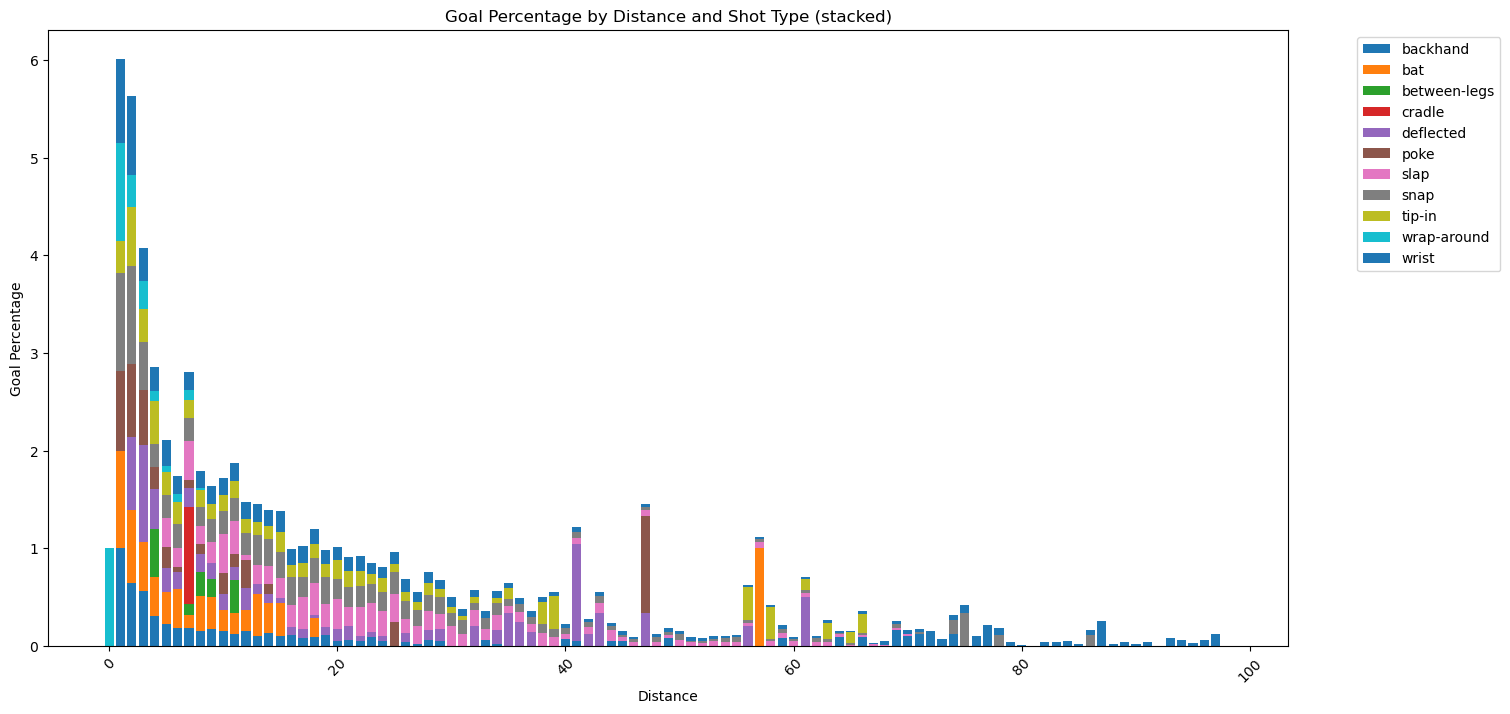

In [448]:

fig, ax = plt.subplots(figsize=(16, 8))

# Plot each shot type as a stacked bar
bottom = np.zeros(len(goal_percentage_by_distance_and_type.columns))
for i, shot_type in enumerate(goal_percentage_by_distance_and_type.index):
    values = goal_percentage_by_distance_and_type.loc[shot_type].values
    ax.bar(
        goal_percentage_by_distance_and_type.columns,
        values,
        bottom=bottom,
        label=shot_type
    )
    bottom += values  # stack bars

ax.set_xlabel('Distance')
ax.set_ylabel('Goal Percentage')
ax.set_title('Goal Percentage by Distance and Shot Type (stacked)')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()